# hidePS Visualization Notebook

This notebook demonstrates the step-by-step process of the hidePS.py script by visualizing each major step in the pipeline. We'll see how point sources are identified, masked, and filled with random values from surrounding pixels.

## What This Notebook Shows:
1. Loading and displaying the original FITS image
2. Parsing DS9 region files
3. Creating and visualizing region masks
4. Extracting pixels from annulus regions
5. Filling regions with random values
6. Comparing before/after results

In [18]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm, PowerNorm
from astropy.io import fits
from astropy.wcs import WCS
import re
from tqdm import tqdm
from pathlib import Path

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['font.size'] = 10

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Create Test Data

First, let's create a test FITS image with point sources if you don't have one available.

In [19]:
def create_test_image_and_regions():
    """Create a test FITS image with point sources and a corresponding region file."""
    
    # Create test image
    size = 512
    background = np.random.normal(100, 10, (size, size)).astype(np.float32)
    
    # Add point sources
    sources = [
        (100, 100, 1000),  # x, y, intensity
        (200, 150, 800),
        (350, 300, 1200),
        (450, 400, 600),
        (300, 450, 900)
    ]
    
    for x, y, intensity in sources:
        # Create Gaussian point sources
        y_grid, x_grid = np.mgrid[0:size, 0:size]
        sigma = 2.0
        gaussian = intensity * np.exp(-((x_grid - x)**2 + (y_grid - y)**2) / (2 * sigma**2))
        background += gaussian
    
    # Add extended emission
    y_grid, x_grid = np.mgrid[0:size, 0:size]
    extended = 50 * np.exp(-((x_grid - size/2)**2 + (y_grid - size/2)**2) / (2 * (size/6)**2))
    background += extended
    
    # Create FITS header
    header = fits.Header()
    header['SIMPLE'] = True
    header['BITPIX'] = -32
    header['NAXIS'] = 2
    header['NAXIS1'] = size
    header['NAXIS2'] = size
    header['CRPIX1'] = size / 2
    header['CRPIX2'] = size / 2
    header['CRVAL1'] = 180.0
    header['CRVAL2'] = 0.0
    header['CDELT1'] = -0.001
    header['CDELT2'] = 0.001
    header['CTYPE1'] = 'RA---TAN'
    header['CTYPE2'] = 'DEC--TAN'
    header['OBJECT'] = 'Test Image'
    
    # Save test image
    test_fits = 'test_data/test_image.fits'
    hdu = fits.PrimaryHDU(data=background, header=header)
    hdu.writeto(test_fits, overwrite=True)
    
    # Create region file
    test_regions = 'test_data/test_regions.reg'
    with open(test_regions, 'w') as f:
        f.write("# Region file format: DS9 version 4.1\n")
        f.write("global color=green dashlist=8 3 width=1\n")
        f.write("image\n")
        for x, y, intensity in sources:
            radius = 7
            f.write(f"circle({x}, {y}, {radius})\n")
    
    print(f"✓ Created test FITS image: {test_fits}")
    print(f"✓ Created test region file: {test_regions}")
    print(f"✓ Point sources at: {[(x, y) for x, y, _ in sources]}")
    
    return test_fits, test_regions, sources

# Create test data
test_fits_file, test_region_file, test_sources = create_test_image_and_regions()

✓ Created test FITS image: test_data/test_image.fits
✓ Created test region file: test_data/test_regions.reg
✓ Point sources at: [(100, 100), (200, 150), (350, 300), (450, 400), (300, 450)]


## Step 1: Load and Display Original FITS Image

Let's load the FITS file and examine its structure, then display the original image.

FITS file: test_data/test_image.fits
Image shape: (512, 512)
Data type: float32
Min value: 57.56
Max value: 1335.74
Mean value: 109.11


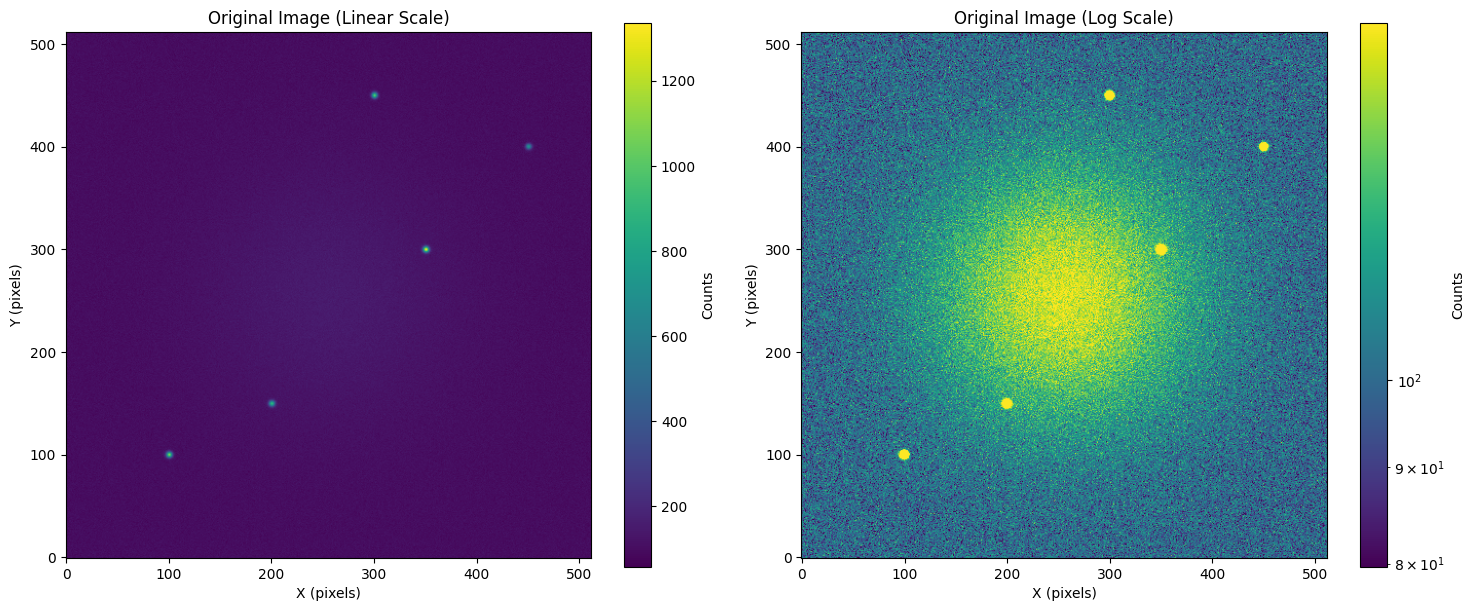

In [20]:
# Load FITS file
fits_file = test_fits_file  # Change this to your actual FITS file if required
hdu_list = fits.open(fits_file)
image_data = hdu_list[0].data.astype(np.float32)
header = hdu_list[0].header

print(f"FITS file: {fits_file}")
print(f"Image shape: {image_data.shape}")
print(f"Data type: {image_data.dtype}")
print(f"Min value: {np.nanmin(image_data):.2f}")
print(f"Max value: {np.nanmax(image_data):.2f}")
print(f"Mean value: {np.nanmean(image_data):.2f}")

# Handle different image dimensions
if image_data.ndim == 2:
    image_2d = image_data
elif image_data.ndim == 3:
    image_2d = image_data[0]
    print("Using first slice of 3D data")
elif image_data.ndim == 4:
    image_2d = image_data[0, 0]
    print("Using first slice of 4D data")
else:
    raise ValueError(f"Unsupported image dimensions: {image_data.ndim}")

try:
    wcs= WCS(header, naxis=2)
    has_wcs = True
except:
    wcs = None
    has_wcs = False
    print("No valid WCS found in FITS header.")

# Display the original image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Linear scale
im1 = ax1.imshow(image_2d, origin='lower', cmap='viridis')
ax1.set_title('Original Image (Linear Scale)')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
plt.colorbar(im1, ax=ax1, label='Counts')

# Log scale for better contrast
vmin = np.nanpercentile(image_2d[image_2d > 0], 1)
vmax = np.nanpercentile(image_2d, 99)
im2 = ax2.imshow(image_2d, origin='lower', cmap='viridis', 
                 norm=LogNorm(vmin=vmin, vmax=vmax))
ax2.set_title('Original Image (Log Scale)')
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Y (pixels)')
plt.colorbar(im2, ax=ax2, label='Counts')

plt.tight_layout()
plt.show()

# Store original data for later comparison
original_image = image_2d.copy()
height, width = image_2d.shape

## Step 2: Parse DS9 Region File

Now let's parse the region file and extract the geometric parameters of each region.

In [21]:
# Copy the Region class and parsing function from the original script
class Region:
    """Region class for basic geometric shapes."""
    
    def __init__(self, shape_type, center_x, center_y, *params):
        self.shape_type = shape_type.lower()
        self.center_x = float(center_x)
        self.center_y = float(center_y)
        self.params = [float(p) for p in params]
    
    def contains_point(self, x, y):
        """Check if a point is inside the region."""
        dx = x - self.center_x
        dy = y - self.center_y
        
        if self.shape_type == 'circle':
            radius = self.params[0]
            return (dx*dx + dy*dy) <= radius*radius
        
        elif self.shape_type == 'ellipse':
            a = self.params[0]  # semi-major axis
            b = self.params[1]  # semi-minor axis
            angle = self.params[2] if len(self.params) > 2 else 0.0
            
            # Rotate coordinates
            cos_a = np.cos(np.radians(angle))
            sin_a = np.sin(np.radians(angle))
            dx_rot = dx * cos_a + dy * sin_a
            dy_rot = -dx * sin_a + dy * cos_a
            
            return (dx_rot*dx_rot)/(a*a) + (dy_rot*dy_rot)/(b*b) <= 1.0
        
        return False
    
    def create_expanded(self, expand_factor):
        """Create an expanded version of this region using a multiplicative factor."""
        if self.shape_type == 'circle':
            new_params = [self.params[0] * expand_factor]
        elif self.shape_type == 'ellipse':
            new_params = [self.params[0] * expand_factor, 
                          self.params[1] * expand_factor]
            if len(self.params) > 2:
                new_params.append(self.params[2])  # Keep angle
        else:
            new_params = self.params
        
        return Region(self.shape_type, self.center_x, self.center_y, *new_params)

def parse_ds9_region_line(line):
    """Parse a single line from a DS9 region file."""
    line = line.split('#')[0].strip()
    if not line:
        return None
    
    # Parse circle
    circle_match = re.match(r'circle\s*\(\s*([^,]+),\s*([^,]+),\s*([^)]+)\)', line)
    if circle_match:
        x, y, r = circle_match.groups()
        return Region('circle', x, y, r)
    
    # Parse ellipse
    ellipse_match = re.match(r'ellipse\s*\(\s*([^,]+),\s*([^,]+),\s*([^,]+),\s*([^,]+)(?:,\s*([^)]+))?\)', line)
    if ellipse_match:
        x, y, a, b, angle = ellipse_match.groups()
        if angle is None:
            angle = 0.0
        return Region('ellipse', x, y, a, b, angle)
    
    print(f"Warning: Could not parse region line: {line}")
    return None

In [22]:
min_show = 3 # Number of regions to show

In [23]:
# Parse the region file
region_file = test_region_file  # Change this to your actual region file if desired
regions = []

with open(region_file, 'r') as f:
    lines = f.readlines()

for line in lines:
    line = line.strip()
    if not line or line.startswith('#') or line.startswith('global') or \
       'fk5' in line.lower() or 'icrs' in line.lower() or 'image' in line.lower():
        continue
    
    region = parse_ds9_region_line(line)
    if region:
        regions.append(region)

print(f"✓ Parsed {len(regions)} regions from {region_file}")
print("\nRegion details:")
for i, region in enumerate(regions[:min_show]):
    if region.shape_type == 'circle':
        print(f"  {i+1}. Circle at ({region.center_x:.1f}, {region.center_y:.1f}) pix "
              f"with radius {region.params[0]:.1f} pix")
    elif region.shape_type == 'ellipse':
        angle = region.params[2] if len(region.params) > 2 else 0.0
        print(f"  {i+1}. Ellipse at ({region.center_x:.1f}, {region.center_y:.1f}) "
              f"with axes {region.params[0]:.1f}x{region.params[1]:.1f}, angle {angle:.1f}°")

✓ Parsed 5 regions from test_data/test_regions.reg

Region details:
  1. Circle at (100.0, 100.0) pix with radius 7.0 pix
  2. Circle at (200.0, 150.0) pix with radius 7.0 pix
  3. Circle at (350.0, 300.0) pix with radius 7.0 pix


## Step 3: Visualize Detected Regions

Let's overlay the parsed regions on the original image to verify they're correctly positioned.

In [24]:
expand_factor = 1.5 # Multiplicative factor to expand regions

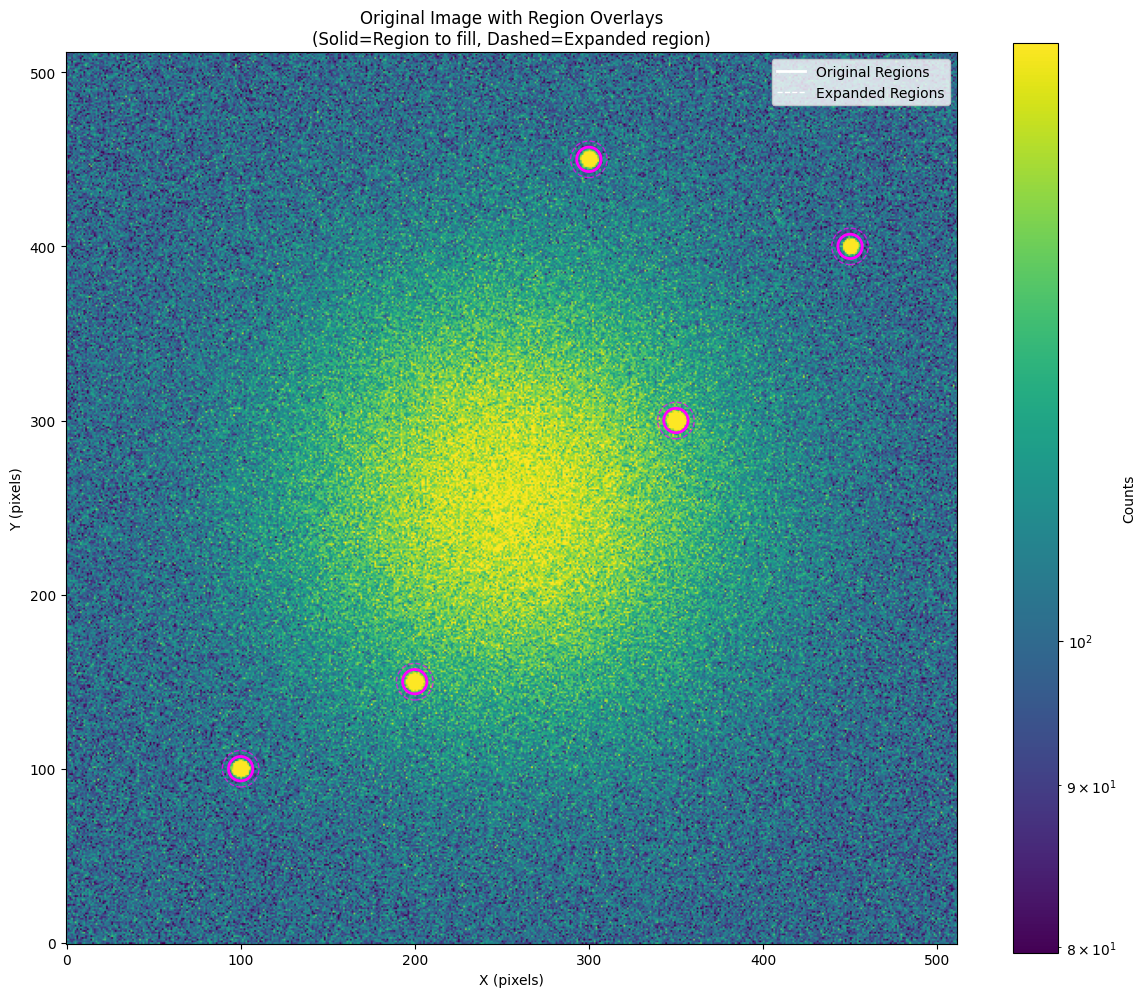

In [25]:
# Create visualization with region overlays
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Display the image
vmin = np.nanpercentile(image_2d[image_2d > 0], 1)
vmax = np.nanpercentile(image_2d, 99)
im = ax.imshow(image_2d, origin='lower', cmap='viridis', 
               norm=LogNorm(vmin=vmin, vmax=vmax))

# Add region overlays
colors = ['red', 'yellow', 'cyan', 'magenta', 'orange']

for i, region in enumerate(regions):
    color = colors[i % len(colors)]
    
    if region.shape_type == 'circle':
        # Original region
        circle = patches.Circle((region.center_x, region.center_y), 
                               region.params[0], 
                               linewidth=2, edgecolor='magenta', 
                               facecolor='none', linestyle='-',
                               label=f'Region {i+1}' if i == 0 else "")
        ax.add_patch(circle)
        
        # Expanded region (annulus outer boundary)
        expanded_radius = region.create_expanded(expand_factor).params[0]
        expanded = patches.Circle((region.center_x, region.center_y), 
                                 expanded_radius, 
                                 linewidth=1, edgecolor='magenta', 
                                 facecolor='none', linestyle='--', alpha=0.7)
        ax.add_patch(expanded)
        
    elif region.shape_type == 'ellipse':
        # Original region
        angle = region.params[2] if len(region.params) > 2 else 0.0
        ellipse = patches.Ellipse((region.center_x, region.center_y),
                                 2*region.params[0], 2*region.params[1],
                                 angle=angle, linewidth=2, edgecolor=color,
                                 facecolor='none', linestyle='-')
        ax.add_patch(ellipse)
        
        # Expanded region
        expanded_a = region.create_expanded(expand_factor).params[0]
        expanded_b = region.create_expanded(expand_factor).params[1]
        expanded = patches.Ellipse((region.center_x, region.center_y),
                                  2*(expanded_a), 
                                  2*(expanded_b),
                                  angle=angle, linewidth=1, edgecolor=color,
                                  facecolor='none', linestyle='--', alpha=0.7)
        ax.add_patch(expanded)

ax.set_title('Original Image with Region Overlays\n(Solid=Region to fill, Dashed=Expanded region)')
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='white', lw=2, label='Original Regions'),
                   Line2D([0], [0], color='white', lw=1, linestyle='--', label='Expanded Regions')]
ax.legend(handles=legend_elements, loc='upper right')

plt.colorbar(im, ax=ax, label='Counts')
plt.tight_layout()
plt.show()

## Step 4: Create Region Masks

Now let's create boolean masks for each region and visualize them.

In [26]:
def create_region_mask(region, height, width):
    """Create a boolean mask for pixels inside a region."""
    mask = np.zeros((height, width), dtype=bool)
    
    # Check each pixel
    for y in range(height):
        for x in range(width):
            if region.contains_point(x, y):
                mask[y, x] = True
    
    return mask

In [27]:
# Create masks for all regions
region_masks = []
expanded_masks = []
annulus_masks = []

for i, region in enumerate(regions):
    # Original region mask
    region_mask = create_region_mask(region, height, width)
    region_masks.append(region_mask)
    
    # Expanded region mask
    expanded_region = region.create_expanded(expand_factor)
    expanded_mask = create_region_mask(expanded_region, height, width)
    expanded_masks.append(expanded_mask)
    
    # Annulus mask (expanded - original)
    annulus_mask = expanded_mask & ~region_mask
    annulus_masks.append(annulus_mask)

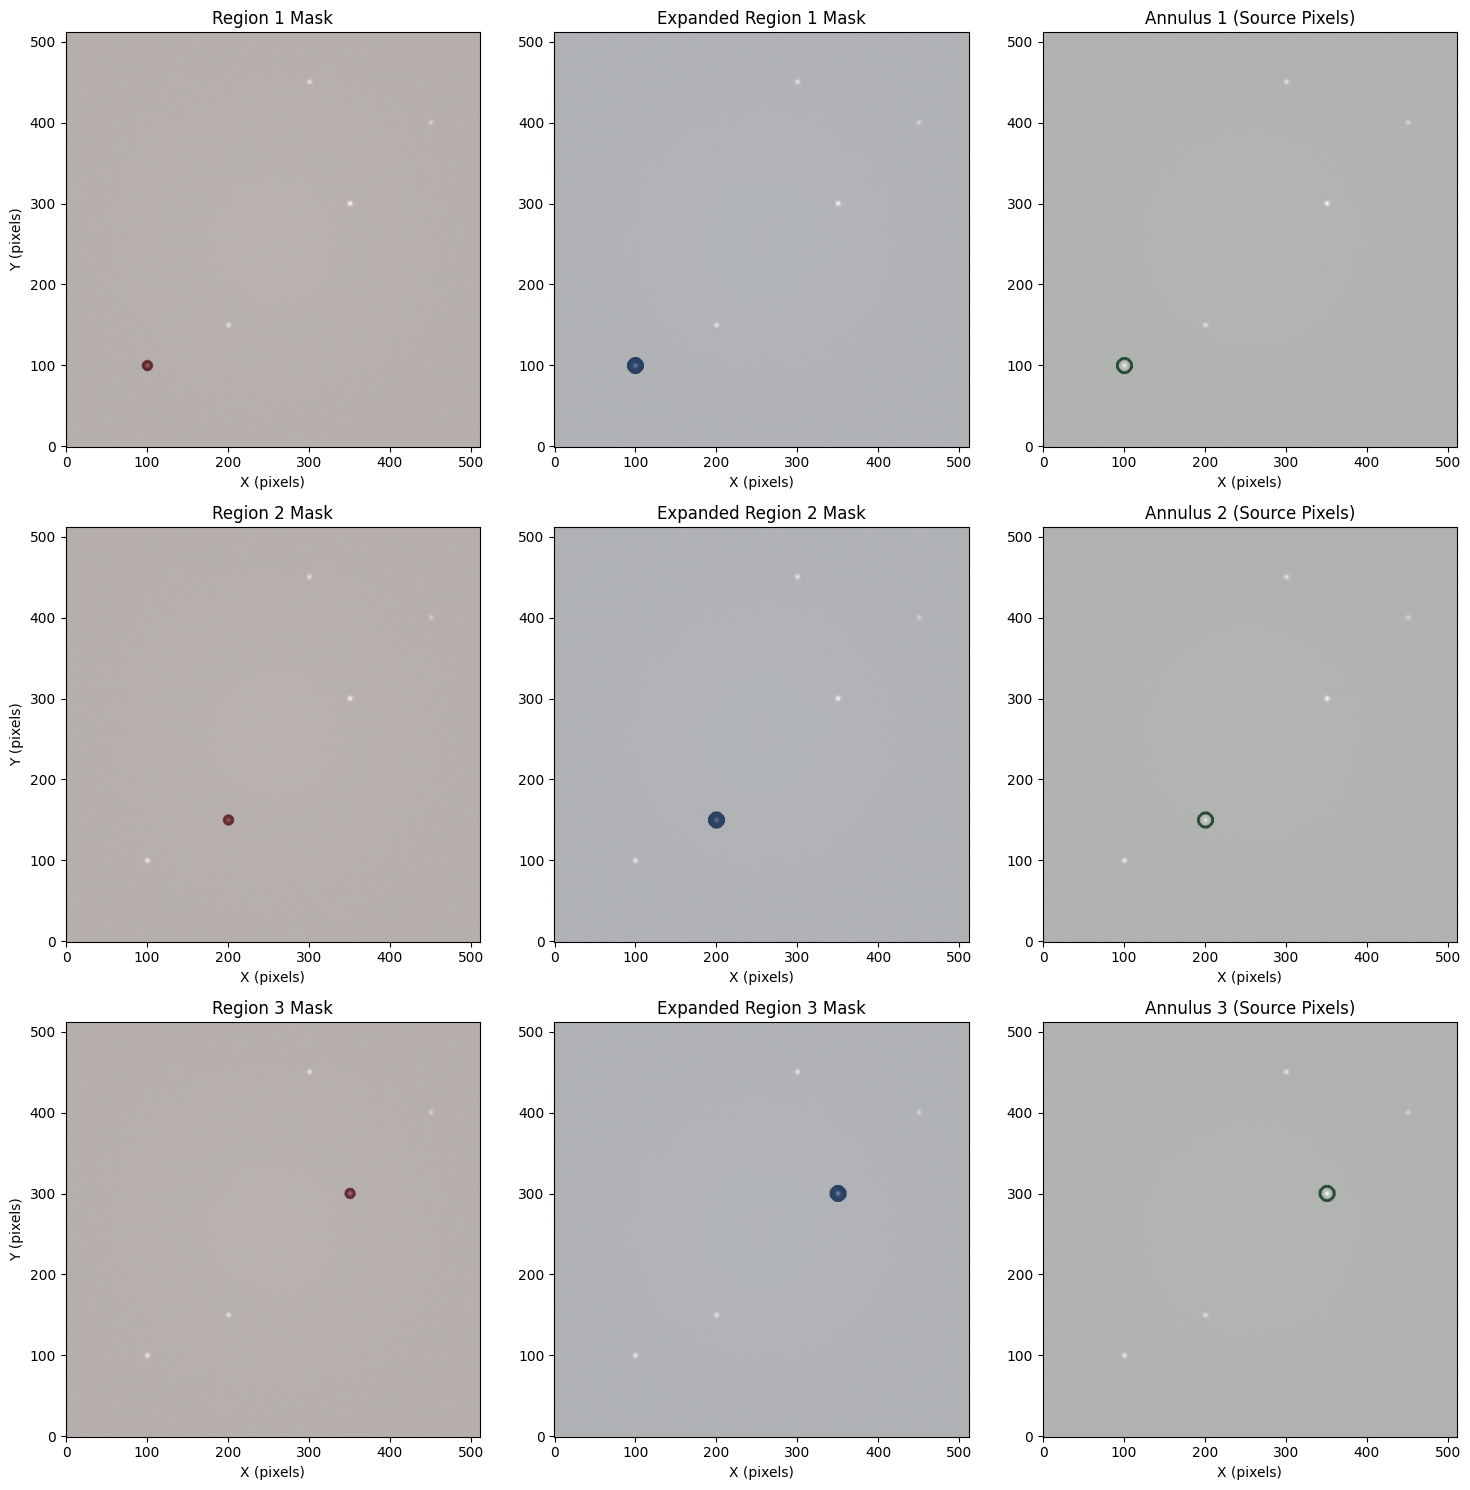

Mask Statistics:
  Region 1: 149 pixels to fill, 200 background pixels
  Region 2: 149 pixels to fill, 200 background pixels
  Region 3: 149 pixels to fill, 200 background pixels


In [28]:
# Visualize masks for first few regions
n_show = min(min_show, len(regions))
fig, axes = plt.subplots(n_show, 3, figsize=(15, 5*n_show))
if n_show == 1:
    axes = axes.reshape(1, -1)

for i in range(n_show):
    # Original region mask
    axes[i, 0].imshow(region_masks[i], origin='lower', cmap='Reds', alpha=0.8)
    axes[i, 0].imshow(image_2d, origin='lower', cmap='gray', alpha=0.3)
    axes[i, 0].set_title(f'Region {i+1} Mask')
    axes[i, 0].set_xlabel('X (pixels)')
    axes[i, 0].set_ylabel('Y (pixels)')
    
    # Expanded region mask
    axes[i, 1].imshow(expanded_masks[i], origin='lower', cmap='Blues', alpha=0.8)
    axes[i, 1].imshow(image_2d, origin='lower', cmap='gray', alpha=0.3)
    axes[i, 1].set_title(f'Expanded Region {i+1} Mask')
    axes[i, 1].set_xlabel('X (pixels)')
    
    # Annulus mask
    axes[i, 2].imshow(annulus_masks[i], origin='lower', cmap='Greens', alpha=0.8)
    axes[i, 2].imshow(image_2d, origin='lower', cmap='gray', alpha=0.3)
    axes[i, 2].set_title(f'Annulus {i+1} (Source Pixels)')
    axes[i, 2].set_xlabel('X (pixels)')

plt.tight_layout()
plt.show()

# Print mask statistics
print("Mask Statistics:")
for i, region in enumerate(regions[:min_show]):
    n_region = np.sum(region_masks[i])
    n_annulus = np.sum(annulus_masks[i])
    print(f"  Region {i+1}: {n_region} pixels to fill, {n_annulus} background pixels")

## Step 5: Extract Annulus Pixels and Analyze Distributions

Let's examine the pixel values we'll be sampling from for each region.

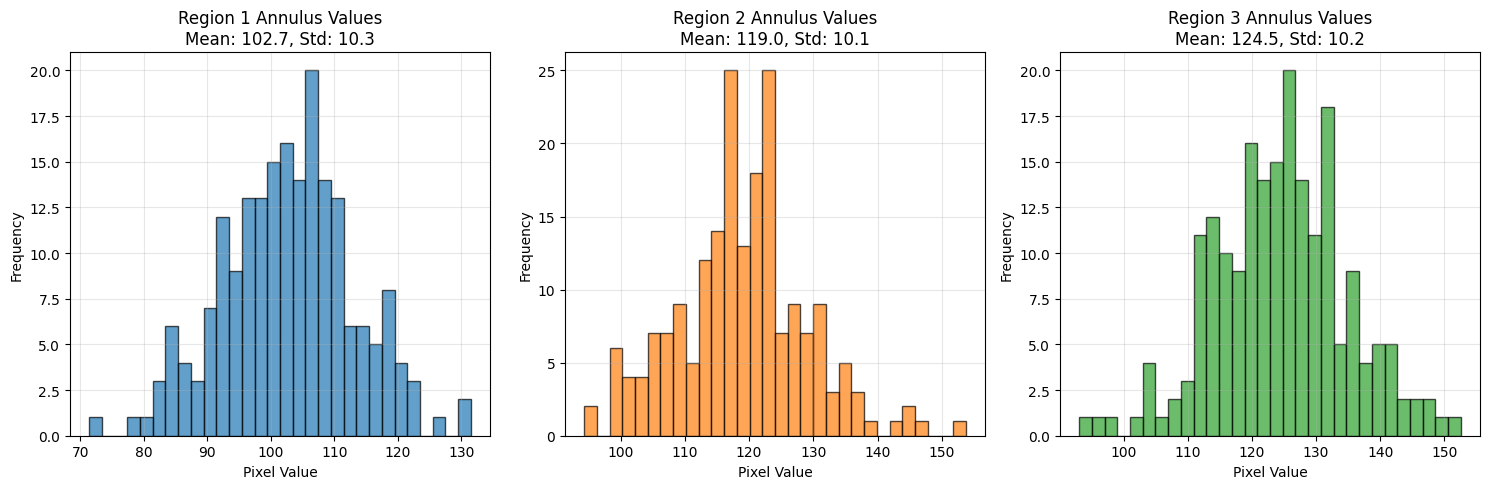

Annulus Pixel Statistics:
  Region 1: 200 pixels, range [71.4, 131.5], mean 102.7 ± 10.3
  Region 2: 200 pixels, range [94.3, 153.8], mean 119.0 ± 10.1
  Region 3: 200 pixels, range [93.1, 152.6], mean 124.5 ± 10.2


In [29]:
# Extract pixel values from annulus regions
annulus_values_list = []

for i, annulus_mask in enumerate(annulus_masks):
    annulus_values = image_2d[annulus_mask]
    finite_values = annulus_values[np.isfinite(annulus_values)]
    annulus_values_list.append(finite_values)

# Plot histograms of annulus values
n_regions = len(regions[:min_show])
fig, axes = plt.subplots((n_regions + 2) // 3, 3, figsize=(15, 5*((n_regions + 2) // 3)))
if n_regions == 1:
    axes = [axes]
elif n_regions <= 2:
    axes = axes.reshape(-1)
else:
    axes = axes.flatten()

for i, values in enumerate(annulus_values_list[:min_show]):
    if i < len(axes):
        axes[i].hist(values, bins=30, alpha=0.7, color=f'C{i}', edgecolor='black')
        axes[i].set_title(f'Region {i+1} Annulus Values\n'
                         f'Mean: {np.mean(values):.1f}, Std: {np.std(values):.1f}')
        axes[i].set_xlabel('Pixel Value')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for j in range(len(annulus_values_list), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Print statistics
print("Annulus Pixel Statistics:")
for i, values in enumerate(annulus_values_list[:min_show]):
    print(f"  Region {i+1}: {len(values)} pixels, "
          f"range [{np.min(values):.1f}, {np.max(values):.1f}], "
          f"mean {np.mean(values):.1f} ± {np.std(values):.1f}")

## Step 6: Apply Region Filling Step by Step

Now let's apply the region filling process and visualize each step.


Processing region 1...
  ✓ Filled 149 pixels with random values
    Original mean in region: 270.4
    New mean in region: 101.9

Processing region 2...
  ✓ Filled 149 pixels with random values
    Original mean in region: 254.9
    New mean in region: 118.9

Processing region 3...
  ✓ Filled 149 pixels with random values
    Original mean in region: 325.6
    New mean in region: 123.8


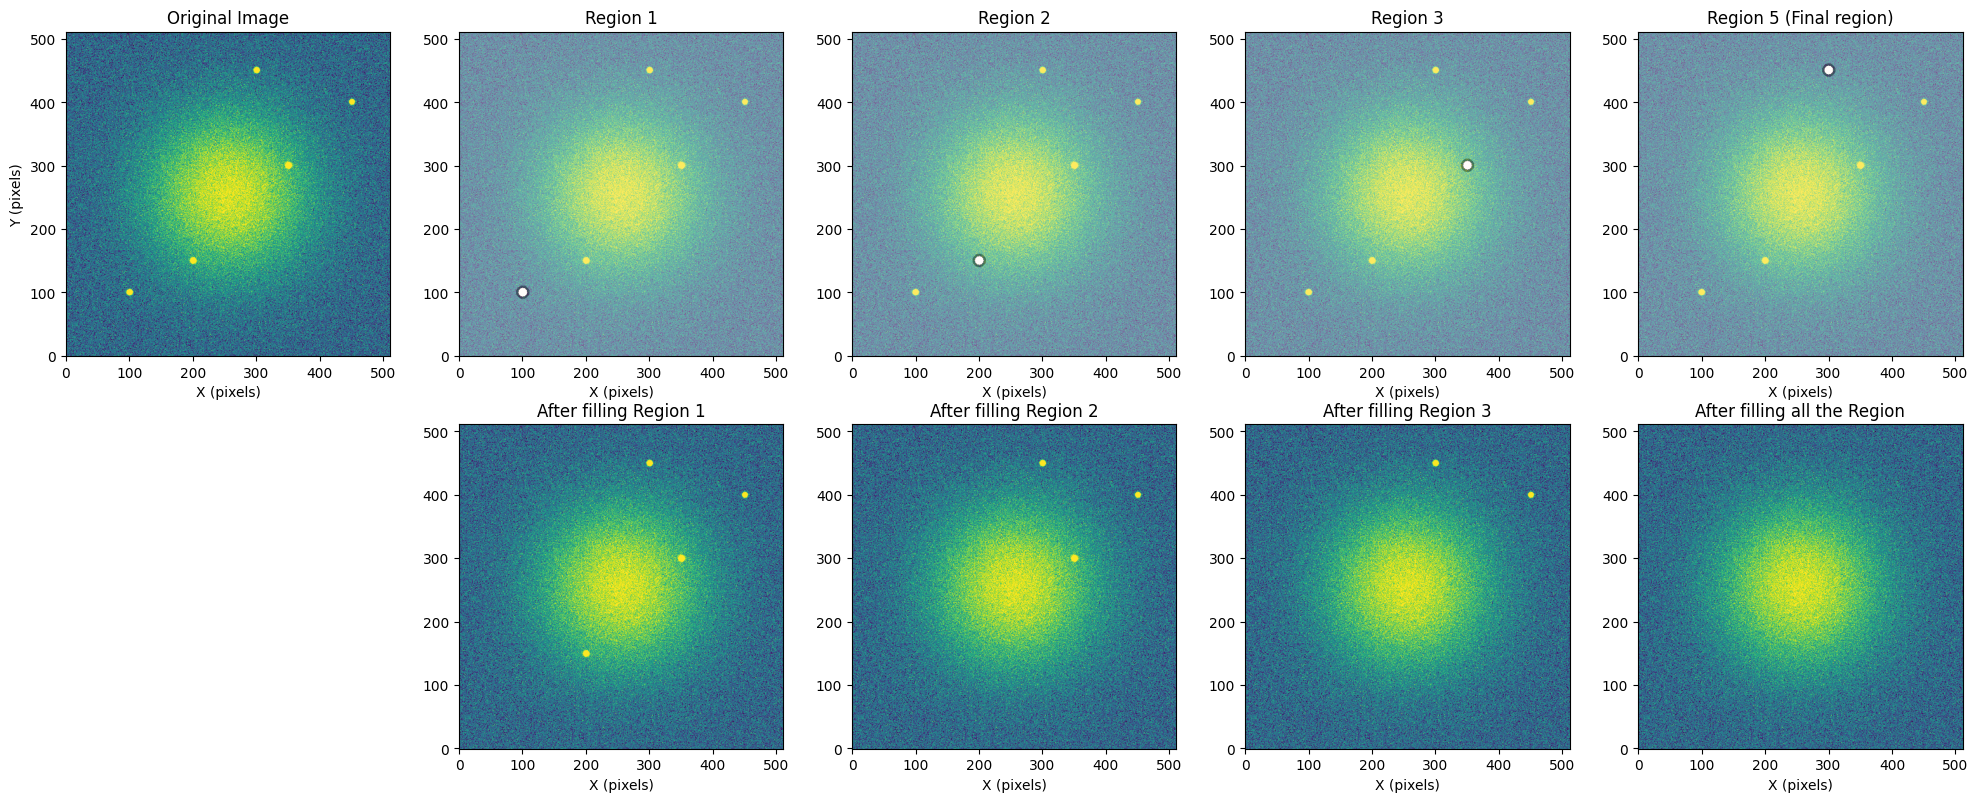

In [30]:
# Create a copy of the original image for processing
processed_image = image_2d.copy()

# Process each region and visualize the steps
no_columns = len(regions[:min_show]) + 2 if len(regions) > min_show else len(regions) + 1
fig, axes = plt.subplots(2, no_columns, figsize=(4*(no_columns), 8))
if len(regions) == 0:
    print("No regions to process!")
else:
    # Show original image in first column
    axes[0, 0].imshow(image_2d, origin='lower', cmap='viridis', 
                      norm=LogNorm(vmin=vmin, vmax=vmax))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].set_xlabel('X (pixels)')
    axes[0, 0].set_ylabel('Y (pixels)')

    axes[1, 0].axis('off')
    
    # Process each region
    for i, region in enumerate(regions):
        # Get masks
        region_mask = region_masks[i]
        annulus_values = annulus_values_list[i]
        
        if len(annulus_values) == 0:
            print(f"  Warning: No pixels found in annulus for region {i+1}")
            continue
        
        # Get number of pixels to fill
        n_pixels_to_fill = np.sum(region_mask)
        
        if n_pixels_to_fill == 0:
            print(f"  Warning: No pixels to fill in region {i+1}")
            continue
        
        # Generate random samples
        np.random.seed(42 + i)  # For reproducible results
        random_indices = np.random.randint(0, len(annulus_values), n_pixels_to_fill)
        random_values = annulus_values[random_indices]
        
        # Fill the region
        processed_image[region_mask] = random_values
        
        if i <= min_show-1:
            print(f"\nProcessing region {i+1}...")
        
            print(f"  ✓ Filled {n_pixels_to_fill} pixels with random values")
            print(f"    Original mean in region: {np.mean(image_2d[region_mask]):.1f}")
            print(f"    New mean in region: {np.mean(random_values):.1f}")
        
            # Show the region being processed
            col = i + 1
            if col < axes.shape[1]:
                # Top row: show the region and annulus
                region_view = image_2d.copy()
                region_view[region_mask] = np.nan  # Highlight the region
                axes[0, col].imshow(region_view, origin='lower', cmap='viridis',
                                norm=LogNorm(vmin=vmin, vmax=vmax))
                axes[0, col].imshow(annulus_masks[i], origin='lower', cmap='Reds', alpha=0.3)
                axes[0, col].set_title(f'Region {i+1}')
                axes[0, col].set_xlabel('X (pixels)')
                
                # Bottom row: show progressive filling
                axes[1, col].imshow(processed_image, origin='lower', cmap='viridis',
                                norm=LogNorm(vmin=vmin, vmax=vmax))
                axes[1, col].set_title(f'After filling Region {i+1}')
                axes[1, col].set_xlabel('X (pixels)')
        
        elif i==len(regions)-1:
            # fig.subplots_adjust(hspace=0.8)
            region_view = image_2d.copy()
            region_view[region_mask] = np.nan  # Highlight the region
            axes[0, -1].imshow(region_view, origin='lower', cmap='viridis',
                            norm=LogNorm(vmin=vmin, vmax=vmax))
            axes[0, -1].imshow(annulus_masks[i], origin='lower', cmap='Reds', alpha=0.3)
            axes[0, -1].set_title(f'Region {i+1} (Final region)')
            axes[0, -1].set_xlabel('X (pixels)')
            
            # Bottom row: show progressive filling
            axes[1, -1].imshow(processed_image, origin='lower', cmap='viridis',
                            norm=LogNorm(vmin=vmin, vmax=vmax))
            axes[1, -1].set_title(f'After filling all the Region')
            axes[1, -1].set_xlabel('X (pixels)')
        
        else:
            continue

plt.tight_layout()
plt.show()

## Step 7: Compare Before and After Images

Let's create comprehensive comparisons of the original and processed images.

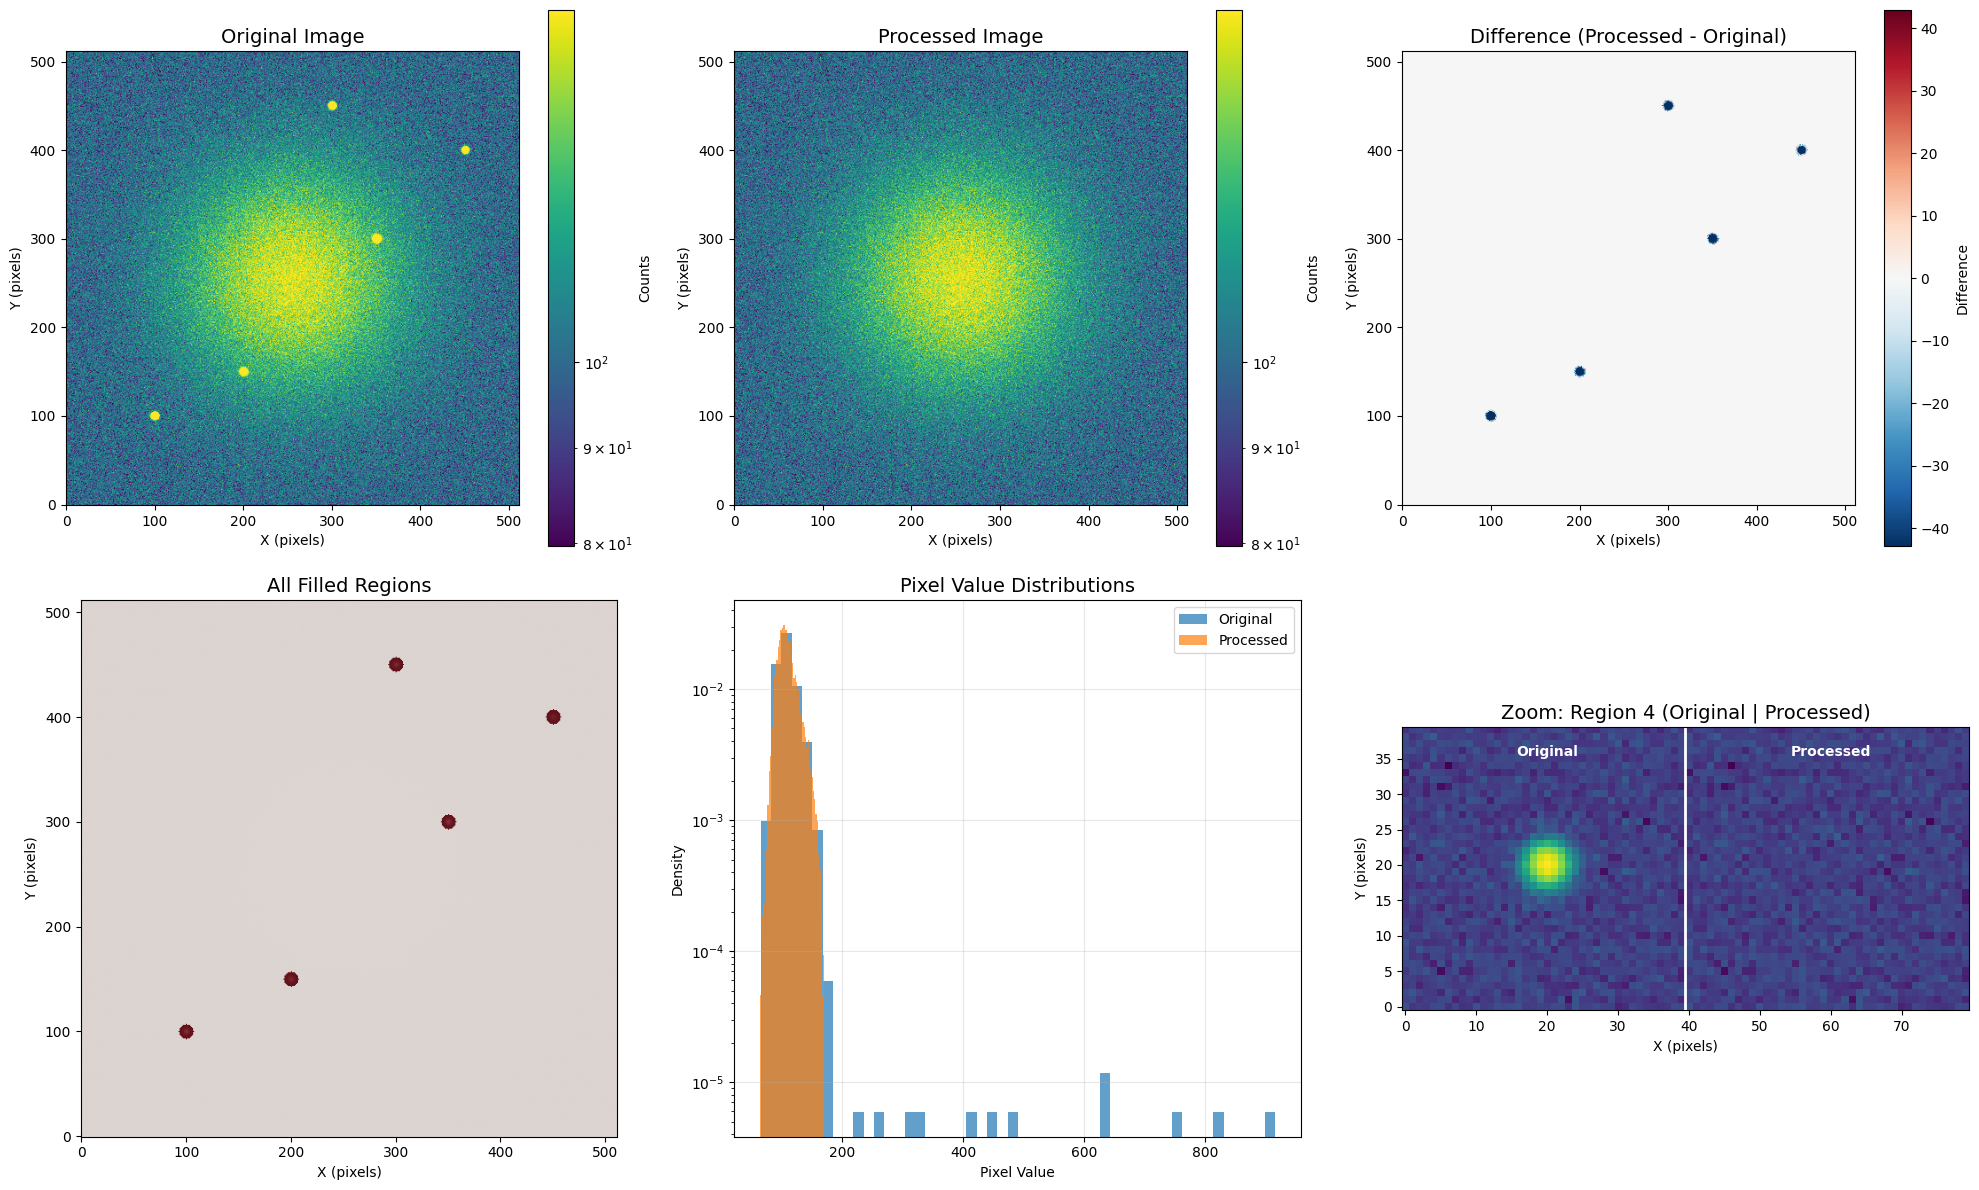


PROCESSING SUMMARY
Original image statistics:
  Mean: 109.11
  Std:  21.19
  Min:  57.56
  Max:  1335.74

Processed image statistics:
  Mean: 108.68
  Std:  15.60
  Min:  57.56
  Max:  188.53

Total pixels modified: 745
Fraction of image modified: 0.3%
RMS difference: 14.31


In [31]:
# Create comprehensive before/after comparison
fig = plt.figure(figsize=(20, 12))

# Original image
ax1 = plt.subplot(2, 3, 1)
im1 = ax1.imshow(image_2d, origin='lower', cmap='viridis',
                 norm=LogNorm(vmin=vmin, vmax=vmax))
ax1.set_title('Original Image', fontsize=14)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
plt.colorbar(im1, ax=ax1, label='Counts')

# Processed image
ax2 = plt.subplot(2, 3, 2)
im2 = ax2.imshow(processed_image, origin='lower', cmap='viridis',
                 norm=LogNorm(vmin=vmin, vmax=vmax))
ax2.set_title('Processed Image', fontsize=14)
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Y (pixels)')
plt.colorbar(im2, ax=ax2, label='Counts')

# Difference image
ax3 = plt.subplot(2, 3, 3)
difference = processed_image - image_2d
im3 = ax3.imshow(difference, origin='lower', cmap='RdBu_r', 
                 vmin=-np.std(difference)*3, vmax=np.std(difference)*3)
ax3.set_title('Difference (Processed - Original)', fontsize=14)
ax3.set_xlabel('X (pixels)')
ax3.set_ylabel('Y (pixels)')
plt.colorbar(im3, ax=ax3, label='Difference')

# Combined mask showing all regions
ax4 = plt.subplot(2, 3, 4)
combined_mask = np.zeros_like(image_2d, dtype=bool)
for mask in region_masks:
    combined_mask |= mask
ax4.imshow(image_2d, origin='lower', cmap='gray', alpha=0.7)
ax4.imshow(combined_mask, origin='lower', cmap='Reds', alpha=0.8)
ax4.set_title('All Filled Regions', fontsize=14)
ax4.set_xlabel('X (pixels)')
ax4.set_ylabel('Y (pixels)')

# Histogram comparison
ax5 = plt.subplot(2, 3, 5)
# Sample pixels for histogram (to avoid memory issues)
sample_size = min(10000, image_2d.size)
orig_sample = np.random.choice(image_2d.flatten(), sample_size, replace=False)
proc_sample = np.random.choice(processed_image.flatten(), sample_size, replace=False)

ax5.hist(orig_sample, bins=50, alpha=0.7, label='Original', density=True)
ax5.hist(proc_sample, bins=50, alpha=0.7, label='Processed', density=True)
ax5.set_yscale('log')
ax5.set_xlabel('Pixel Value')
ax5.set_ylabel('Density')
ax5.set_title('Pixel Value Distributions', fontsize=14)
ax5.legend()
ax5.grid(True, alpha=0.3)

# Zoomed view of one region
ax6 = plt.subplot(2, 3, 6)
if len(regions) > 0:
    # Focus on first region
    index = 3 # Change index as needed.
    region = regions[index] 
    margin = 20
    x_min = max(0, int(region.center_x - margin))
    x_max = min(width, int(region.center_x + margin))
    y_min = max(0, int(region.center_y - margin))
    y_max = min(height, int(region.center_y + margin))
    
    # Create side-by-side zoomed view
    zoom_orig = image_2d[y_min:y_max, x_min:x_max]
    zoom_proc = processed_image[y_min:y_max, x_min:x_max]
    
    # Combine horizontally
    zoom_combined = np.hstack([zoom_orig, zoom_proc])
    
    im6 = ax6.imshow(zoom_combined, origin='lower', cmap='viridis',
                     norm=LogNorm(vmin=np.nanmin(zoom_combined[zoom_combined > 0]), 
                                  vmax=np.nanmax(zoom_combined)))
    ax6.axvline(x=zoom_orig.shape[1]-0.5, color='white', linewidth=2)
    ax6.set_title(f'Zoom: Region {index+1} (Original | Processed)', fontsize=14)
    ax6.set_xlabel('X (pixels)')
    ax6.set_ylabel('Y (pixels)')
    
    # Add text labels
    ax6.text(zoom_orig.shape[1]//2, zoom_orig.shape[0]-3, 'Original', 
             ha='center', va='top', color='white', fontweight='bold')
    ax6.text(zoom_orig.shape[1] + zoom_proc.shape[1]//2, zoom_orig.shape[0]-3, 
             'Processed', ha='center', va='top', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("PROCESSING SUMMARY")
print("="*60)

print(f"Original image statistics:")
print(f"  Mean: {np.mean(image_2d):.2f}")
print(f"  Std:  {np.std(image_2d):.2f}")
print(f"  Min:  {np.min(image_2d):.2f}")
print(f"  Max:  {np.max(image_2d):.2f}")

print(f"\nProcessed image statistics:")
print(f"  Mean: {np.mean(processed_image):.2f}")
print(f"  Std:  {np.std(processed_image):.2f}")
print(f"  Min:  {np.min(processed_image):.2f}")
print(f"  Max:  {np.max(processed_image):.2f}")

total_pixels_modified = sum(np.sum(mask) for mask in region_masks)
print(f"\nTotal pixels modified: {total_pixels_modified}")
print(f"Fraction of image modified: {total_pixels_modified/image_2d.size:.1%}")

difference_rms = np.sqrt(np.mean(difference**2))
print(f"RMS difference: {difference_rms:.2f}")

## Step 8: Save the Output

Finally, let's save the processed image.

In [32]:
# Save the processed image
output_filename = 'test_data/test_image_processed.fits'

# Create new HDU with processed data
new_header = header.copy()
new_header['HISTORY'] = 'Processed with hidePS visualization notebook'
new_header['HISTORY'] = f'Point sources filled with random surrounding values'
new_header['HISTORY'] = f'Processed {len(regions)} regions'

# Handle different original dimensions
if image_data.ndim == 2:
    new_data = processed_image
elif image_data.ndim == 3:
    new_data = image_data.copy()
    new_data[0] = processed_image
elif image_data.ndim == 4:
    new_data = image_data.copy()
    new_data[0, 0] = processed_image

# Save to file
primary_hdu = fits.PrimaryHDU(data=new_data, header=new_header)
hdu_list_out = fits.HDUList([primary_hdu])
hdu_list_out.writeto(output_filename, overwrite=True)

print(f"✓ Saved processed image to: {output_filename}")

✓ Saved processed image to: test_data/test_image_processed.fits
